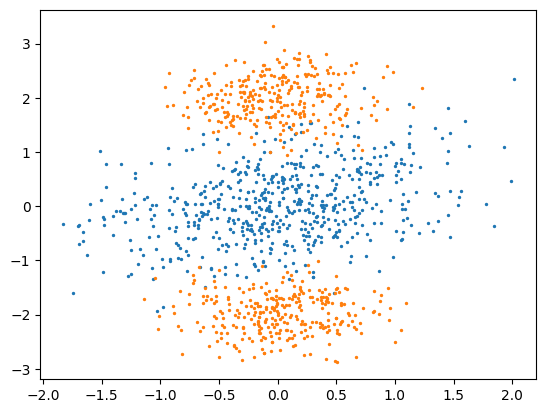

i: 0, loss: 0.9709528380540835
i: 1, loss: 0.5099975186745827
i: 2, loss: 0.2830558281647589
i: 3, loss: 0.14334571028929488
i: 4, loss: 0.1483186653947829
i: 5, loss: 0.1687043571389202
i: 6, loss: 0.12255680303650843
i: 7, loss: 0.07929713802114423
i: 8, loss: 0.05888328123073239
i: 9, loss: 0.05847224848637665
i: 10, loss: 0.059583085141026566
i: 11, loss: 0.07504427421837466
i: 12, loss: 0.06827661098469566
i: 13, loss: 0.049239609057708016
i: 14, loss: 0.04411060140230807
i: 15, loss: 0.044225417140047664
i: 16, loss: 0.04848454462205785
i: 17, loss: 0.04467451928098033
i: 18, loss: 0.03446093547556558
i: 19, loss: 0.02980376808935197
i: 20, loss: 0.029161450766264637
i: 21, loss: 0.030623177371872545
i: 22, loss: 0.032385152006368906
i: 23, loss: 0.029950440480784758
i: 24, loss: 0.02895503815683673
i: 25, loss: 0.025910760751581195
i: 26, loss: 0.025692472490316864
i: 27, loss: 0.026748947385611208
i: 28, loss: 0.026511577584007302
i: 29, loss: 0.025703490143075713
i: 30, loss: 

In [1]:
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from fbs.dsb import ipf_fwd_loss, ipf_bwd_loss, simulate_discrete_time

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_disable_jit", True)

# Config
nsamples = 600
niters = 1000
key = jax.random.PRNGKey(999)
nn_float = jnp.float64
nn_param_init = nn.initializers.xavier_normal()

dt = 0.01
nsteps = 100
T = nsteps * dt
ts = jnp.linspace(0, T, nsteps + 1)


# Toy data
def sample_x0s(_key):
    _, _subkey = jax.random.split(_key)
    ss = jax.random.normal(_subkey, (nsamples, 2)) @ jnp.linalg.cholesky(jnp.array([[0.5, 0.2],
                                                                                    [0.2, 0.5]]))
    return jnp.array([0., 0.]) + ss


def sample_xTs(_key):
    _key, _subkey = jax.random.split(_key)
    _c1 = jnp.array([0., 2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    _key, _subkey = jax.random.split(_key)
    _c2 = jnp.array([0., -2.]) + 0.4 * jax.random.normal(_subkey, (int(nsamples / 2), 2))
    return jnp.concatenate([_c1, _c2], axis=0)


key, subkey = jax.random.split(key)
x0s = sample_x0s(subkey)
key, subkey = jax.random.split(key)
xTs = sample_xTs(subkey)
plt.scatter(x0s[:, 0], x0s[:, 1], s=2)
plt.scatter(xTs[:, 0], xTs[:, 1], s=2)
plt.show()


# Reference measure
def drift(x, _):
    return -0.5 * x

sigma = 1.


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=16, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2, param_dtype=nn_float, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param_fwd, _, nn_fwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)
key, subkey = jax.random.split(key)
init_param_bwd, _, nn_bwd = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)

schedule = optax.exponential_decay(1e-2, niters, 0.96)
optimiser = optax.adam(learning_rate=schedule)
f_param = init_param_fwd
b_param = init_param_bwd


# The first IPF iteration
def init_f(x, t, _): return x


@jax.jit
def optax_kernel_init(_b_param, _opt_state, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_fwd_loss)(_b_param, _, init_f, nn_bwd, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_fwd(_b_param, _opt_state, _f_param, _key):
    _key, _subkey = jax.random.split(_key)
    _x0s = sample_x0s(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_fwd_loss)(_b_param, _f_param, nn_fwd, nn_bwd, _x0s, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _b_param)
    _b_param = optax.apply_updates(_b_param, updates)
    return _b_param, _opt_state, _loss


@jax.jit
def optax_kernel_bwd(_f_param, _opt_state, _b_param, _key):
    _key, _subkey = jax.random.split(_key)
    _xTs = sample_xTs(_subkey)
    _, _subkey = jax.random.split(_key)
    _loss, grad = jax.value_and_grad(ipf_bwd_loss)(_f_param, _b_param, nn_fwd, nn_bwd, _xTs, ts, sigma, _subkey)
    updates, _opt_state = optimiser.update(grad, _opt_state, _f_param)
    _f_param = optax.apply_updates(_f_param, updates)
    return _f_param, _opt_state, _loss


opt_state = optimiser.init(b_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    b_param, opt_state, loss = optax_kernel_init(b_param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

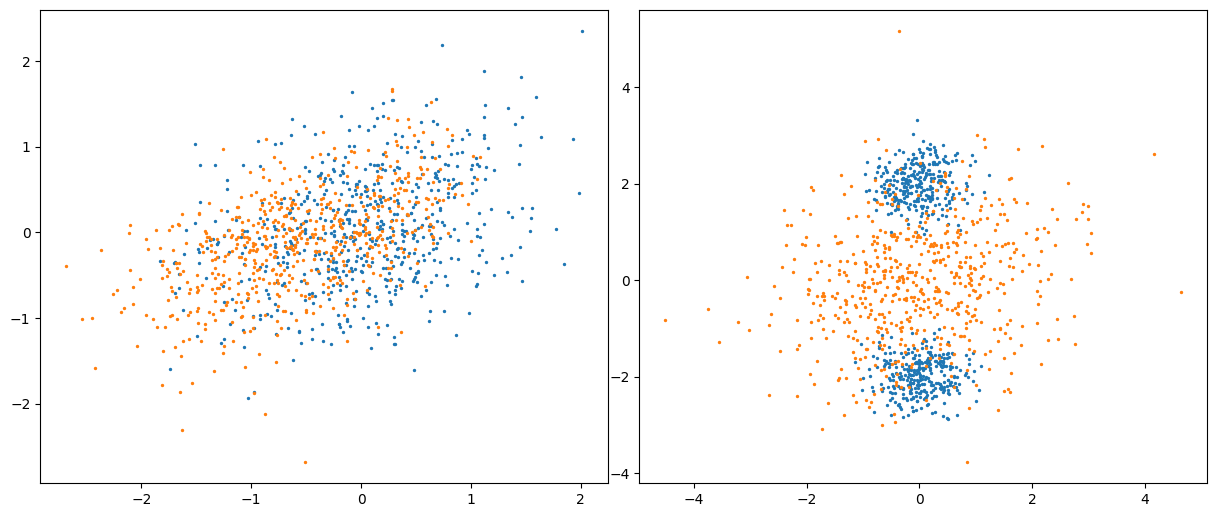

In [2]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(init_f, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2)

plt.tight_layout(pad=0.1)
plt.show()

In [3]:
opt_state = optimiser.init(f_param)

for i in range(niters):
    key, subkey = jax.random.split(key)
    f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 4.188044102514171
i: 1, loss: 1.741370615828094
i: 2, loss: 0.560959063920965
i: 3, loss: 0.3406414806906151
i: 4, loss: 0.6521765711762844
i: 5, loss: 0.5954026878342622
i: 6, loss: 0.34547694971683407
i: 7, loss: 0.14188459638390635
i: 8, loss: 0.16068246958284088
i: 9, loss: 0.2578522275290538
i: 10, loss: 0.29340497559656525
i: 11, loss: 0.2596119857966426
i: 12, loss: 0.20041504574884292
i: 13, loss: 0.1517020415921719
i: 14, loss: 0.08528484836609891
i: 15, loss: 0.06092661665089882
i: 16, loss: 0.0930083691542917
i: 17, loss: 0.13572877826695837
i: 18, loss: 0.13554921379676776
i: 19, loss: 0.10657201985496535
i: 20, loss: 0.07312623482942598
i: 21, loss: 0.05449093252535977
i: 22, loss: 0.047383606538522846
i: 23, loss: 0.060637223091278294
i: 24, loss: 0.0742972770773924
i: 25, loss: 0.07758052068077331
i: 26, loss: 0.0689168792108222
i: 27, loss: 0.05021789887573659
i: 28, loss: 0.043714874219260215
i: 29, loss: 0.03367680093823882
i: 30, loss: 0.03072435325637886

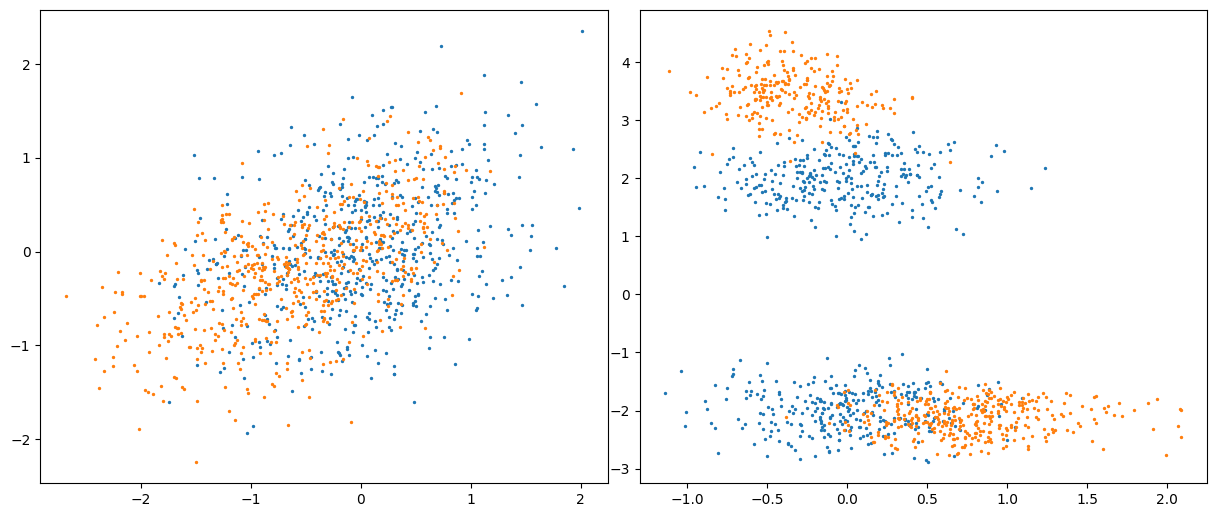

In [11]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2)
# axes[1].set_xlim(-4, 4)
# axes[1].set_ylim(-4, 4)

plt.tight_layout(pad=0.1)
plt.show()

In [ ]:
# IPF iterations
for j in range(10):
    opt_state = optimiser.init(b_param)

    for i in range(niters):
        key, subkey = jax.random.split(key)
        b_param, opt_state, loss = optax_kernel_fwd(b_param, opt_state, f_param, subkey)
        print(f'j: {j}, i: {i}, forward loss: {loss}')

    opt_state = optimiser.init(f_param)

    for i in range(niters):
        key, subkey = jax.random.split(key)
        f_param, opt_state, loss = optax_kernel_bwd(f_param, opt_state, b_param, subkey)
        print(f'j: {j}, i: {i}, backward loss: {loss}')

In [ ]:
# Take a look
key, subkey = jax.random.split(key)
approx_xTs = simulate_discrete_time(nn_fwd, x0s, ts, sigma, subkey, f_param)[:, -1, :]

key, subkey = jax.random.split(key)
approx_x0s = simulate_discrete_time(nn_bwd, xTs, ts, sigma, subkey, b_param)[:, -1, :]

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(x0s[:, 0], x0s[:, 1], s=2)
axes[0].scatter(approx_x0s[:, 0], approx_x0s[:, 1], s=2)

axes[1].scatter(xTs[:, 0], xTs[:, 1], s=2)
axes[1].scatter(approx_xTs[:, 0], approx_xTs[:, 1], s=2)

plt.tight_layout(pad=0.1)
plt.show()